In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import explode
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import datetime
from pyspark.sql import Window

spark = SparkSession \
            .builder \
            .appName("Analyze_PATH_delays") \
            .getOrCreate()


In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt

# schema

In [2]:
gmail_payload_header_schema=StructType([
    StructField("name",StringType(),True),
    StructField("value",StringType(),True)
])
gmail_payload_schema=StructType([
    StructField("partId",StringType(),True),
    StructField("mimeType",StringType(),True),
    StructField("filename",StringType(),True),
    StructField("headers",ArrayType(gmail_payload_header_schema),True)
    
])
gmail_schema=StructType([
    StructField("id",StringType(),True),
    StructField("threadId",StringType(),True),
    StructField("labelIds",ArrayType(StringType()),True),
    StructField("snippet",StringType(),True),
    StructField("historyId",StringType(),True),
    StructField("internalDate",StringType(),True),
    StructField("payload",gmail_payload_schema,True),
    StructField("sizeEstimate",StringType(),True)
    
])


# udf

In [3]:
concat_list=udf(lambda x: ';'.join(x) if x is not None and iter(x) else x, StringType())

def pdate(data):
    '''
    Mon, 19 Sep 2016 10:56:45 -0400 ==> %a, %d %b %Y %H:%M:%S %z
    19 Sep 2016 10:56:45 -0400 ==> %d %b %Y %H:%M:%S %z
    '''
    known_formats=['%a, %d %b %Y %H:%M:%S %z','%d %b %Y %H:%M:%S %z']

    for format in known_formats:
        try:
            p_date=datetime.strptime(data,format)
            return "2000-"+datetime.strftime(p_date,"%m-%d")
        except ValueError:
            continue

udf_pdate=udf(pdate,StringType())

# process

In [4]:
#read json file using the schema
df_gmails=spark.read.schema(gmail_schema).json('gmail_paalerts.json')

In [5]:
df_gmails.printSchema()

root
 |-- id: string (nullable = true)
 |-- threadId: string (nullable = true)
 |-- labelIds: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- snippet: string (nullable = true)
 |-- historyId: string (nullable = true)
 |-- internalDate: string (nullable = true)
 |-- payload: struct (nullable = true)
 |    |-- partId: string (nullable = true)
 |    |-- mimeType: string (nullable = true)
 |    |-- filename: string (nullable = true)
 |    |-- headers: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- value: string (nullable = true)
 |-- sizeEstimate: string (nullable = true)



Explore **STACK and EXPLODE ** functions

In [6]:
'''
Not all these metadata are needed for the analysis. Just an example here of how and where some of these functions can be used to transform the data
'''
df_gmails_top_metadata=df_gmails.select("id","threadId",concat_list("labelIds").alias("labelIds"),"snippet","historyId"
                                   ,"internalDate","payload.partId","payload.mimeType","payload.filename","sizeEstimate")\
                                .selectExpr("id","stack(9,'threadId',threadId,\
                                                'labelIds',labelIds,'snippet',snippet,\
                                                'historyId',historyId,'internalDate',internalDate,\
                                                'partId',partId,'mimeType',mimeType,\
                                                'filename',filename,'sizeEstimate',sizeEstimate) as (FieldName,Value)")

In [7]:
df_gmails_dynamic_metadata=df_gmails.select("id",explode("payload.headers").alias("header"))\
    .select("id","header.name","header.value")

In [8]:
df_gmails_vertical_metadata = df_gmails_top_metadata.union(df_gmails_dynamic_metadata).repartition("id")

In [9]:
'''
Spark SQL along with Dataframe allow readability

'''

#Pivot transforms Column to Row which allows further filtering by the column name
df_delays=df_gmails_vertical_metadata.filter("Id is not null and lower(FieldName) in('date','snippet')")\
                                   .groupBy("id").pivot("FieldName").agg(first("Value"))\
                                   .filter("lower(snippet) not like '%resuming%normal%schedule%'")\
                                   .orderBy("Id")

#
df_delays=df_delays.select("id","date","snippet").withColumn("p_date",udf_pdate(col("date")).cast("date")).drop("date")


df_delays=df_delays.select("id","snippet","p_date").selectExpr("id","snippet","case when p_date between '2000-03-20' and '2000-06-19' then 'Spring'\
                                                                                   when p_date between '2000-06-20' and '2000-09-21' then 'Summer'\
                                                                                   when p_date between '2000-09-22' and '2000-12-20' then 'Fall'\
                                                                                   when ( p_date between '2000-12-21' and '2000-12-31') OR (p_date between '2000-01-01' and '2000-03-19') then 'Winter' end as Season")\
                                                   .filter("snippet not like '%resuming%normal%' and snippet like '%delay%'")\
                                                   .select("id","season").distinct()


df_delays_season=df_delays.groupBy("Season").agg({"id":"count"})

In [10]:
df_delays_season=df_delays_season.withColumnRenamed("count(id)","delays_count")

In [11]:
df_delays_pie=df_delays_season.select('Season','delays_count').toPandas()

# Analytics report

<IPython.core.display.Javascript object>


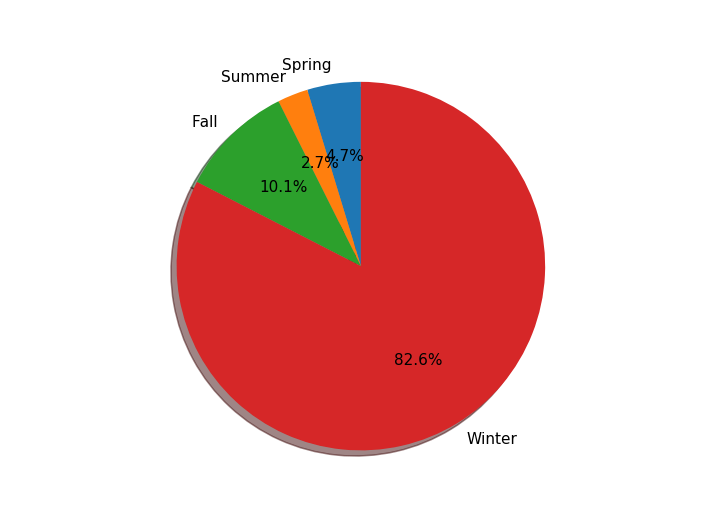

In [15]:
# Pie chart
labels = df_delays_pie['Season']
sizes = df_delays_pie['delays_count']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

# Natural Language Processing

Reasons for the delays were found using natural language processing using AWS Comprehend. Most frequent reasons are reported in the chart. 

In [16]:
df_key_phrases= spark.read\
    .format("jdbc")\
    .option("url", "jdbc:sqlserver://Server:Port;instance=SQLExpress;database=nlp")\
    .option("driver","com.microsoft.sqlserver.jdbc.SQLServerDriver")\
    .option("dbtable","keyphrases")\
    .option("user","sa")\
    .option("password","password")\
    .load()


In [17]:
df_key_phrases.show(5,truncate=False)

+-------+----------------+---------------+------------------+-----------+---------+
|auto_id|id              |key_phrase     |score             |beginoffset|endoffset|
+-------+----------------+---------------+------------------+-----------+---------+
|1      |161446d3920bb761|police activity|0.9578627943992615|7          |22       |
|2      |161446d3920bb761|service        |0.9633626937866211|24         |31       |
|3      |161446d3920bb761|the HOB-33 line|0.9755499958992004|35         |50       |
|4      |161446d3920bb761|a delay        |0.9867852330207825|69         |76       |
|5      |161446d3920bb761|Manage         |0.3865080773830414|78         |84       |
+-------+----------------+---------------+------------------+-----------+---------+
only showing top 5 rows



In [18]:
window=Window.partitionBy("id").orderBy("beginOffset")

df_delay_reasons=df_key_phrases.select("id","key_phrase",row_number().over(window).alias("orderNo")).filter("orderNo=1")\
                             .groupBy("key_phrase").agg({"id":"count"}).withColumnRenamed("count(id)","occurence")\
                             .orderBy(["occurence"],ascending=[0])

In [19]:
df_delays_bar=df_delay_reasons.toPandas()

In [20]:
top_reasons=df_delays_bar[0:5]
list(top_reasons['key_phrase'])

['a signal problem',
 'a car equipment problem',
 'a track condition',
 'weather related problems',
 'police activity']

<IPython.core.display.Javascript object>


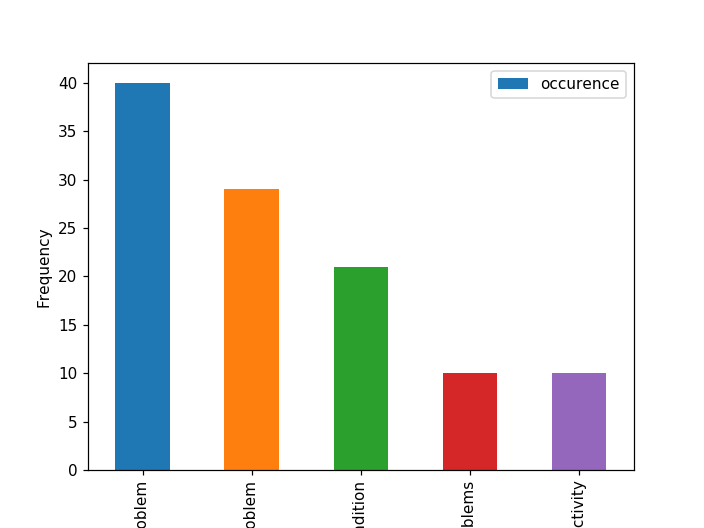

In [21]:
ax=top_reasons.plot('key_phrase','occurence',kind='bar')

ax.set_xlabel("Reason")
ax.set_ylabel("Frequency")
